# Notebook para experimentación
Éste notebook permite la experimentación con el modelo propuesto. Dentro de las cosas que permite éste notebook están:

Éste programa permite el ajuste de parámetros como:
* Número de palabras en el diccionario: `n_words`
* Dimensión del espacio embebido: `embed_dim`
* Dimensión de salida de la capa de la red LSTM: `lstm_out`
* Tamaño de bache de entrenamiento: `batch_size`
* Número de épocas: `n_epochs`
* Variables de entrenamiento: `training_vars`
* Variable a predecir: `pred_var`

## Leer la base de datos de entrenamiento

In [1]:
from rama4d.files import select_file
from rama4d.preprocessing import read_database, clean_dataframe, preprocess_text

Descargando modelo de Spacy...
✔ Download and installation successful
You can now load the model via spacy.load('es_core_news_md')


In [2]:
training_file = select_file()
print(f'Base de datos de entrenamiento:\n\t-{training_file}')

Base de datos de entrenamiento:
	-/home/ssilvari/Documents/code/rama4d/demos/base_de_prueba.xlsx


In [28]:
df = read_database(training_file)
df.sample(2)

DIRECTORIO  MES                                      P6370  OFICIO  \
328      3910834    1  SUPERVISAR PERSONAL DE CARTERA EN EMPRESA      30   
2411     4104268    7             DISEÑAR AGENDAS PERSONALIZADAS      16   

                                                 P6390   Año  P6430  P6880  \
328   CONSTRUCCION DE EDIFICACIONES DE USO RESIDENCIAL  2016      1      7   
2411                  DISEÑO DE AGENDAS PERSONALIZADAS  2016      4      1   

      P6870  p6420s2  ...  test  dif  RAMA4D_CIIU3  RAMA4D_CIIU4  \
328       9      NaN  ...   NaN  NaN          7010          4111   
2411      2      NaN  ...   NaN  NaN          2231          7410   

      RECODIFICACIÓN  NUEVO CÓDIGO                  OBSERVACIÓN  RAMA4D_R4  \
328                1           NaN     Se mantiene codificación       4111   
2411               1           NaN  se mantiene la codificación       7410   

      RAMA2D_R4.1  RAMA1D_R4  
328            41          4  
2411           74          7  

[2 rows x 24 columns]

## Ajuste de parámetros

In [29]:
n_words = 4000
embed_dim = 128
lstm_out = 300
batch_size = 64
n_epochs = 15

**Ejemplo:** Vamos a usar las siguientes variables para predecir el código del oficio a dos dígitos (OFICIO):
* **P6370 (texto)**: ¿Qué hace en éste trabajo?
* **P6880 (categórico-numérica)**:  ¿En qué lugar realiza la actividad?

creamos una lista por cada tipo de variable:
* `text_vars`: Variables tipo texto
* `num_cat_vars`: Variables categorico-numéricas

finalmente concatenamos todo en una lista de variables de interés `training_vars`.

In [30]:
text_vars = ['P6370']
num_cat_vars = ['P6880']

training_vars = text_vars + num_cat_vars
pred_var = 'RAMA1D_R4'

In [31]:
print(f'Variables a analizar: {training_vars}')
print(f'Variable a predecir: {pred_var}')

Variables a analizar: ['P6370', 'P6880']
Variable a predecir: RAMA1D_R4


## Preprocesamiento de variables

Limpiamos la base de datos (imputación de datos perdidos, si los hay):

In [32]:
df = clean_dataframe(df)

Extraemos las variables de interés (`training_set`) y la variable a predecir (`labels`):

In [33]:
training_set = df[training_vars]
labels = df[pred_var]

### Análisis exploratorio
Hacemos una breve descripción del dataset. Un buen inicio es visualizar la cantidad de categorías:

In [34]:
n_classes = len(labels.value_counts())
print(f'Número de categorías: {n_classes}')

Número de categorías: 10


### Preprocesamiento de variables tipo texto
Aplicamos la función `preprocess_text()` a cada variable tipo texto usando el método `apply()`.

In [35]:
p6370_prep = df['P6370'].apply(preprocess_text)
p6370_prep.sample()  # Muestra aleatoria

1997    prepara postres
Name: P6370, dtype: object

Creamos una función que convierta la variable numérico-categórica a texto (de token sencillo):

In [36]:
def p6880_to_text(num_val):
    "Recibe un valor numérico y lo transforma a texto (extraído de encuesta)."
    p6880_dict = {
        1: 'en_vivienda_propia',
        2: 'en_otras_viviendas',
        3: 'En_kiosco_o_caseta',
        4: 'En_un_vehículo',
        5: 'Puerta_a_puerta',
        6: 'Ambulante',
        7: 'En_local_u_oficina',
        8: 'En_el_campo_área_rural_mar_o_río',
        9: 'En_una_obra_de_construcción',
        10: 'En_una_mina_o_cantera',
        11: ''
    }
    return p6880_dict[num_val]

Probamos nuestra función con un caso. **Ejemplo:** Si el valor de P6880 es 6 significa que la actividad es hecha como *Ambulante*.

In [37]:
p6880_to_text(6)

'Ambulante'

Ahora, la aplicamos a la variable categorico-numérica de interés:

In [38]:
p6880_prep = df['P6880'].apply(p6880_to_text)
p6880_prep.sample()

206    en_vivienda_propia
Name: P6880, dtype: object

## Ensamble del texto a procesar
Una simple concatenación de las variables procesadas nos da una serie con el texto a caracterizar:

In [39]:
text_series = p6370_prep + '. ' + p6880_prep
text_series.sample().values[0]  # Imprime muestra aleatoria (texto completo)

'auxiliar contable llevar registros contables. En_local_u_oficina'

## Tokenización (caracterización)
En la etapa de caracterización, se busca convertir el texto a valores numéricos que la máquina puede luego clasificar.

In [40]:
import pandas as pd
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

Configuramos un tokenizador con un diccionario definido arriba por la variable `num_words`

In [41]:
tokenizer = Tokenizer(num_words=n_words, split=' ')
tokenizer.fit_on_texts(text_series)

Y finalmente construimos la matriz de características

In [42]:
X = tokenizer.texts_to_sequences(text_series)
X = pad_sequences(X)  # Matriz de características

## Entrenamiento del modelo

### Codificación de las etiquetas
Un método eficiente para la máquina es utilizar una codificación binaria por cada categiría. Un ejemplo de esto es *One-Hot encoding*.

In [43]:
Y = pd.get_dummies(labels).values

Ya con nuestra matriz de características $\mathbf{X}$ y nuestra matriz de etiquetas $\mathbf{Y}$ podemos proceder a definir la arquitectura y entrenar el modelo:

## Arquitectura de modelo
Usaremos la misma arquitectura propuesta para CIIU4 (Embedding + LSTM + Dense). Una red neuronal recurrente (RNN).

In [44]:
from keras.layers import Dense, Embedding, LSTM
from keras.models import Sequential

In [45]:
model = Sequential()
model.add(Embedding(n_words, embed_dim, input_length=X.shape[1], dropout=0.1))
model.add(LSTM(lstm_out, dropout_U=0.1, dropout_W=0.1))
model.add(Dense(Y.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 30, 128)           512000    
_________________________________________________________________
lstm_2 (LSTM)                (None, 300)               514800    
_________________________________________________________________
dense_2 (Dense)              (None, 10)                3010      
Total params: 1,029,810
Trainable params: 1,029,810
Non-trainable params: 0
_________________________________________________________________


## Entrenamiento
Procedemos a entrenar el modelo. La función de costo (Loss) debe decrementar hasta converger (si no converge, se recomienda aumentar en número de epochs).

In [46]:
print(f'Entrenando modelo...')
history = model.fit(X, Y, batch_size=batch_size, epochs=n_epochs, validation_split=0.33)

Entrenando modelo...
Train on 1677 samples, validate on 826 samples
Epoch 1/15
1677/1677 [==============================] - 5s 3ms/step - loss: 1.8917 - accuracy: 0.3840 - val_loss: 1.5706 - val_accuracy: 0.5351
Epoch 2/15
1677/1677 [==============================] - 4s 3ms/step - loss: 1.4984 - accuracy: 0.4836 - val_loss: 1.2946 - val_accuracy: 0.5327
Epoch 3/15
1677/1677 [==============================] - 4s 2ms/step - loss: 1.3085 - accuracy: 0.5492 - val_loss: 1.2566 - val_accuracy: 0.5835
Epoch 4/15
1677/1677 [==============================] - 4s 2ms/step - loss: 1.1288 - accuracy: 0.6255 - val_loss: 1.3215 - val_accuracy: 0.5787
Epoch 5/15
1677/1677 [==============================] - 4s 2ms/step - loss: 0.9988 - accuracy: 0.6589 - val_loss: 1.1030 - val_accuracy: 0.6138
Epoch 6/15
1677/1677 [==============================] - 4s 2ms/step - loss: 0.8527 - accuracy: 0.6995 - val_loss: 1.0896 - val_accuracy: 0.6259
Epoch 7/15
1677/1677 [==============================] - 4s 2ms/step 

Podemos visualizar la pérdida y el accuracy en el conjunto de entrenamiento y prueba:

In [47]:
import matplotlib.pyplot as plt
plt.style.use('seaborn')

In [48]:
results = pd.DataFrame(history.history)
results.head()

val_loss  val_accuracy      loss  accuracy
0  1.570572      0.535109  1.891659  0.384019
1  1.294606      0.532688  1.498414  0.483602
2  1.256572      0.583535  1.308539  0.549195
3  1.321532      0.578692  1.128770  0.625522
4  1.103014      0.613801  0.998787  0.658915

Graficamos los resultados (función de pérdida y accuracy):

Text(0.5, 1.0, 'Accuracy')

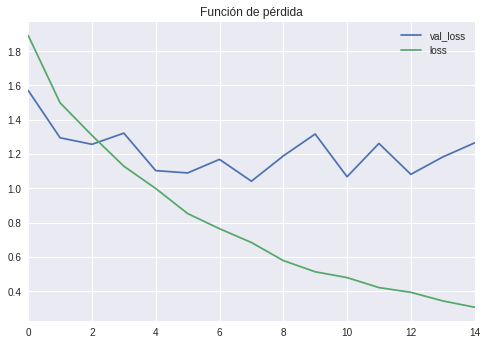

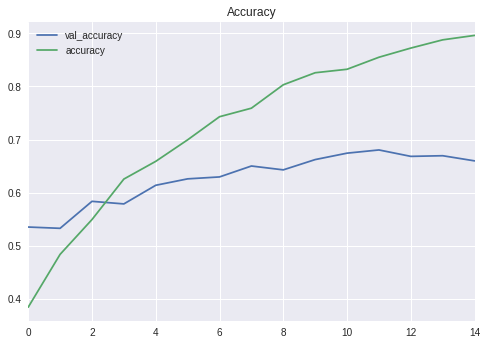

In [50]:
results[['val_loss', 'loss']].plot()
plt.title('Función de pérdida')

results[['val_accuracy', 'accuracy']].plot()
plt.title('Accuracy')